In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

In [14]:
# Load the datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/train',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="training",
    seed=123
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/valid',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="validation",
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/test',
    batch_size=32,
    image_size=(224, 224),
    label_mode=None,
    shuffle=False
)

Found 4200 files belonging to 5 classes.
Using 3360 files for training.
Found 399 files belonging to 5 classes.
Using 79 files for validation.
Found 200 files.


In [15]:
# Retrieve class names
class_names = train_ds.class_names

# Print the class indices
print("Class indices for training generator:", class_names)

Class indices for training generator: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaf', 'Mosaic Disease', 'Powdery_Mildew']


In [16]:

# Prefetching for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [17]:

# Load the ResNet50 model pre-trained on ImageNet without the top classification layer
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained base model layers
resnet50_base.trainable = False

# Build the model
model = Sequential()

# Add the pre-trained ResNet50 base
model.add(resnet50_base)

# Add global average pooling layer to reduce spatial dimensions
model.add(GlobalAveragePooling2D())

# Dropout Layer
model.add(Dropout(0.35))

# Add a dense layer with 220 units and ReLU activation function
model.add(Dense(220, activation='relu'))

# Add the output layer with units equal to the number of classes and softmax activation function for multi-class classification
model.add(Dense(len(class_names), activation='softmax'))

model.summary()




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
# Compile the model
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the callback function
early_stopping = EarlyStopping(patience=10)

# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[early_stopping])



Epoch 1/100
  4/105 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2363 - loss: 2.4174

W0000 00:00:1716954225.558174     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2232 - loss: 2.3052

W0000 00:00:1716954234.926524     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.2235 - loss: 2.3002 - val_accuracy: 0.3418 - val_loss: 1.5567
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3199 - loss: 1.6573 - val_accuracy: 0.3797 - val_loss: 1.4238
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4153 - loss: 1.4136 - val_accuracy: 0.4937 - val_loss: 1.3371
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5061 - loss: 1.2296 - val_accuracy: 0.5063 - val_loss: 1.2574
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5387 - loss: 1.1494 - val_accuracy: 0.5316 - val_loss: 1.2173
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5899 - loss: 1.0603 - val_accuracy: 0.5696 - val_loss: 1.1660
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6035 - loss: 1.0186 - val_accuracy: 0.6329 - val_loss: 1.1146
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6271 - loss: 0.9632 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


W0000 00:00:1716954598.011577     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Accuracy: 0.7468354430379747
Precision: 0.794064461227529
Recall: 0.7468354430379747
F1 Score: 0.7329568434151937


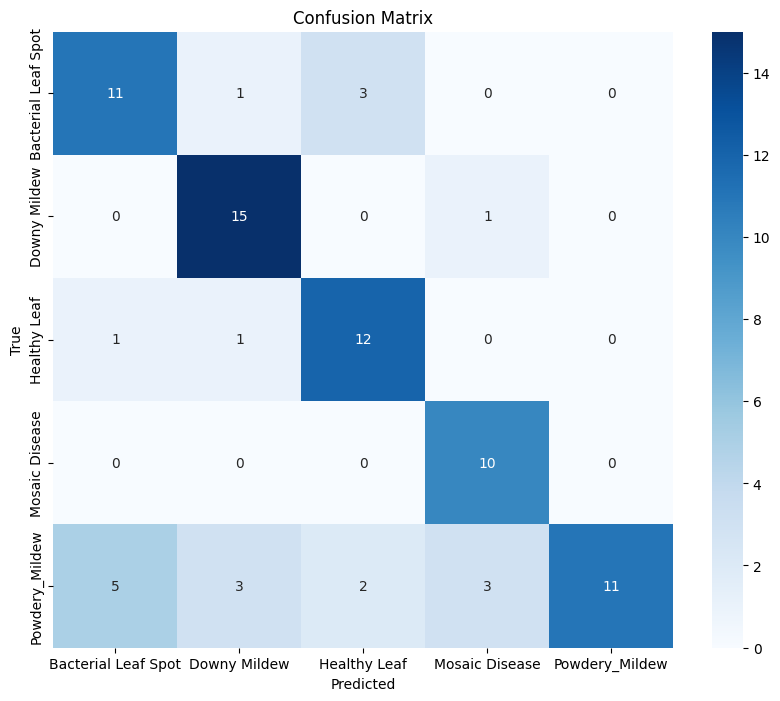

In [19]:

# Calculate and print additional metrics
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

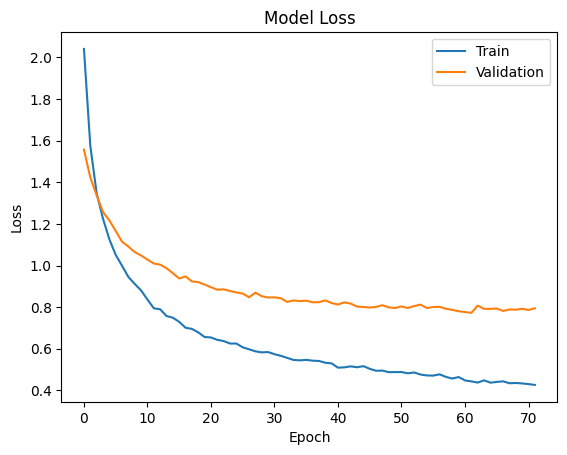

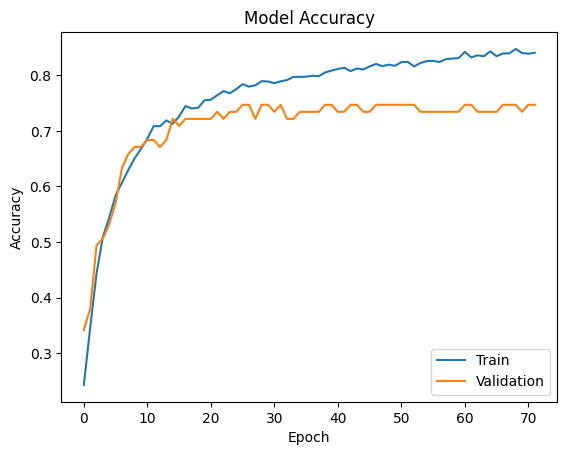

In [20]:

# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
